# Gerekli Kütüphaneler

In [ ]:
# Google Colab'da varsayılan olarak yüklü gelmeyenleri kuruyoruz
!pip install optuna
!pip install shap

# Temel Veri İşleme ve Görselleştirme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Veri Yükleme ve Ön İşleme
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scikit-learn: Model ve Metrikler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)

# İleri Seviye: Optimizasyon ve Açıklanabilirlik (XAI)
import optuna
import shap

# Pandas ayarları (Tüm sütunları görmek için)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Tüm kütüphaneler başarıyla yüklendi ve hazır!")

Tüm kütüphaneler başarıyla yüklendi ve hazır!


# **1. Veri Setinin Yüklenmesi**

# 1.1 scikit-learn'den Veri Seti Yükleme

In [ ]:
# Veri setini yükle
data = load_breast_cancer()

# 1.2 Veri Çerçevesi Oluşturma

In [ ]:
# X (özellikler) ve y (hedef) değişkenlerini ayırma
X = data.data
y = data.target

# pandas DataFrame formatına dönüştürme
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# İlk 5 satırı görüntüleme
print("Veri Setinin İlk 5 Satırı")
display(df.head())

Veri Setinin İlk 5 Satırı


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# **2. Veri Seti Kalite Kontrolleri**

# 2.1 Eksik Değer Analizi

In [ ]:
print("\nEksik Değer Kontrolü")
missing_values = df.isnull().sum()

# Eksik değer varsa uygun yöntemle dolduruyoruz
if missing_values.sum() == 0:
    print("Sonuç: Veri setinde eksik değer bulunmamaktadır.")
else:
    df.fillna(df.mean(), inplace=True)
    print("Sonuç: Eksik değerler ortalama ile dolduruldu.")


Eksik Değer Kontrolü
Sonuç: Veri setinde eksik değer bulunmamaktadır.


# 2.2 Aykırı Değer (Outlier) Analizi - IQR Yöntemi

In [ ]:
print("\nAykırı Değer Analizi (IQR Yöntemi)")
def detect_outliers_iqr(dataframe, columns):
    outlier_indices = []
    for col in columns:
        # Çeyreklikler (Q1 ve Q3) hesaplanıyor
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        # Alt ve üst sınırlar belirleniyor
        outlier_step = 1.5 * IQR

        # Sınırlara uymayan değerler tespit ediliyor
        outliers_col = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)].index
        if len(outliers_col) > 0:
            outlier_indices.extend(outliers_col)

    return list(set(outlier_indices))

# Sadece özellik sütunlarında outlier aranıyor
outliers = detect_outliers_iqr(df, data.feature_names)
print(f"IQR yöntemiyle tespit edilen aykırı değer içeren satır sayısı: {len(outliers)}")


Aykırı Değer Analizi (IQR Yöntemi)
IQR yöntemiyle tespit edilen aykırı değer içeren satır sayısı: 171


# 2.3 Veri Tipi ve Dağılım İncelemesi

In [ ]:
print("\nVeri Tipleri")
# Sütunların dtype bilgilerini göster
print(df.dtypes)

print("\nHedef Değişken Dağılımı (Sayısal/Kategorik)")
# Sayısal / kategorik değişken sayılarını raporla
print(df['target'].value_counts())


Veri Tipleri
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst 

# **3. Keşifsel Veri Analizi (EDA)**

# 3.1 İstatistiksel Özellikler

In [ ]:
# Mean, Median, Min-Max, Std, Q1-Q3 değerleri hesaplanıyor
print("\nİstatistiksel Özellikler Tablosu")
istatistikler = df.describe().T
display(istatistikler[['mean', '50%', 'min', 'max', 'std', '25%', '75%']])


İstatistiksel Özellikler Tablosu


,mean,50%,min,max,std,25%,75%
mean radius,14.127292,13.370000,6.981000,28.11000,3.524049,11.700000,15.780000
mean texture,19.289649,18.840000,9.710000,39.28000,4.301036,16.170000,21.800000
mean perimeter,91.969033,86.240000,43.790000,188.50000,24.298981,75.170000,104.100000
mean area,654.889104,551.100000,143.500000,2501.00000,351.914129,420.300000,782.700000
mean smoothness,0.096360,0.095870,0.052630,0.16340,0.014064,0.086370,0.105300
mean compactness,0.104341,0.092630,0.019380,0.34540,0.052813,0.064920,0.130400
mean concavity,0.088799,0.061540,0.000000,0.42680,0.079720,0.029560,0.130700
mean concave points,0.048919,0.033500,0.000000,0.20120,0.038803,0.020310,0.074000
mean symmetry,0.181162,0.179200,0.106000,0.30400,0.027414,0.161900,0.195700
mean fractal dimension,0.062798,0.061540,0.049960,0.09744,0.007060,0.057700,0.066120


# 3.2 Korelasyon Matrisi ve Heatmap

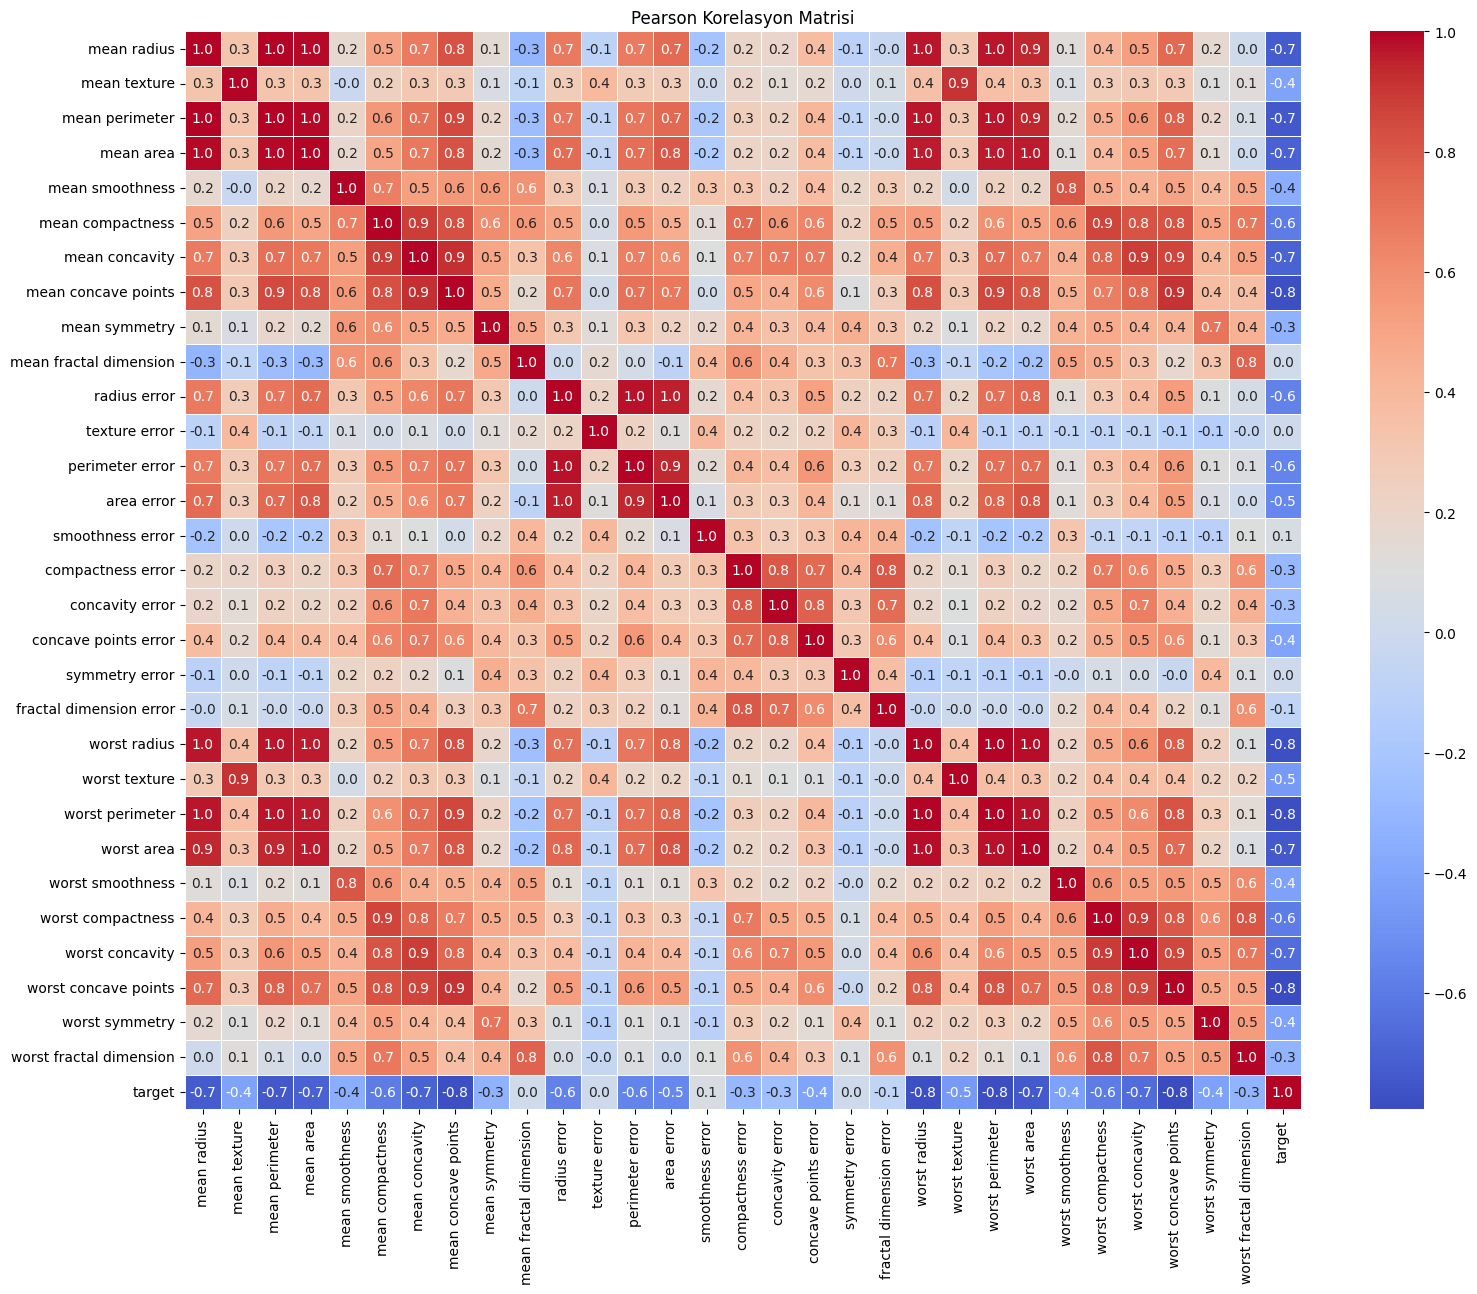


En Yüksek Korelasyonlu 3 Çift
mean radius      mean perimeter    0.997855
worst perimeter  worst radius      0.993708
mean radius      mean area         0.987357
dtype: float64


In [ ]:
# Pearson korelasyon matrisi oluşturuluyor
plt.figure(figsize=(18, 14))
corr_matrix = df.corr()

# Heatmap ile görselleştiriliyor
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Korelasyon Matrisi")
plt.show()

# En yüksek korelasyonlu 3 çift sütunu yorumluyoruz
print("\nEn Yüksek Korelasyonlu 3 Çift")
corr_unstack = corr_matrix.abs().unstack()
corr_unstack = corr_unstack[corr_unstack < 1] # Kendisiyle (1.0) olanları çıkarıyoruz
print(corr_unstack.sort_values(ascending=False).drop_duplicates().head(3))

# 3.3 Boxplot Analizi

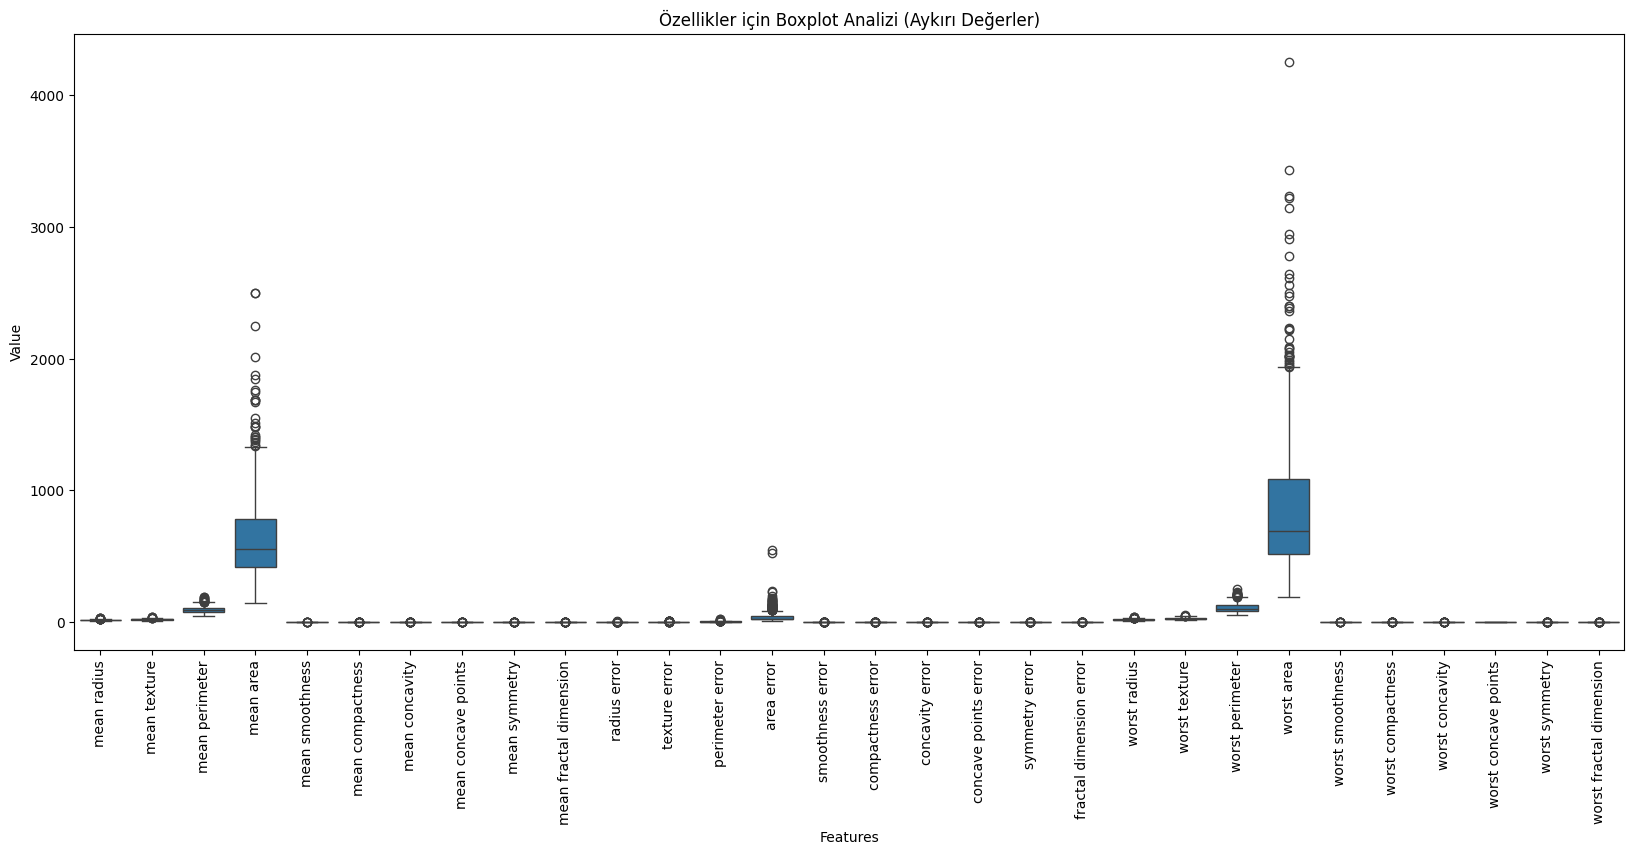

In [ ]:
# Tüm özellikler için boxplot çiziliyor
plt.figure(figsize=(20, 8))
data_melted = pd.melt(df.drop('target', axis=1), var_name="Features", value_name="Value")
sns.boxplot(x="Features", y="Value", data=data_melted)
plt.xticks(rotation=90)
plt.title("Özellikler için Boxplot Analizi (Aykırı Değerler)")
plt.show()

# **4. Veri Ölçeklendirme (Scaling)**

In [ ]:
scaler = StandardScaler()
# Ölçeklendirilmiş veriyi X_scaled olarak kaydediyoruz
X_scaled = scaler.fit_transform(X)

print("\nÖlçeklendirme Tamamlandı")
print(f"X_scaled boyutu: {X_scaled.shape}")
print(f"Örnek (İlk sütun ortalaması ~0 olmalı): {X_scaled[:,0].mean():.2f}")


Ölçeklendirme Tamamlandı
X_scaled boyutu: (569, 30)
Örnek (İlk sütun ortalaması ~0 olmalı): -0.00


# **5. Veri Setinin Bölünmesi**

In [ ]:
# Yönerge: %70 Training, %10 Validation, %20 Test

# Adım 1: Önce Test setini (%20) ayırıyoruz.
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# Adım 2: Kalan veriyi (%80) Train ve Validation olarak bölüyoruz.
# Toplamın %10'u validasyon olacaksa, kalan %80'in 1/8'i validasyondur.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"Training Set (%70): {X_train.shape}")
print(f"Validation Set (%10): {X_val.shape}")
print(f"Test Set (%20): {X_test.shape}")

Training Set (%70): (398, 30)
Validation Set (%10): (57, 30)
Test Set (%20): (114, 30)


# **6. Farklı MLP Modellerinin Kurulması**

In [ ]:
# Yönergede belirtilen 5 farklı model konfigürasyonu tanımlanıyor
models_config = [
    {
        "name": "Model 1 - Basit",
        "params": {"hidden_layer_sizes": (16,), "activation": "relu", "learning_rate_init": 0.001}
    },
    {
        "name": "Model 2 - Orta",
        "params": {"hidden_layer_sizes": (32, 16), "activation": "relu", "learning_rate_init": 0.005}
    },
    {
        "name": "Model 3 - Geniş",
        "params": {"hidden_layer_sizes": (64, 64), "activation": "tanh", "learning_rate_init": 0.001}
    },
    {
        "name": "Model 4 - Derin",
        "params": {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "learning_rate_init": 0.0005}
    },
    {
        "name": "Model 5 - Düşük LR",
        "params": {"hidden_layer_sizes": (32,), "activation": "relu", "learning_rate_init": 0.0001}
    }
]

results = []
trained_models = {} # Modelleri daha sonra kullanmak için saklıyoruz

print("\nModeller Eğitiliyor")


Modeller Eğitiliyor


# **7. Validation Performanslarının Ölçülmesi**

In [ ]:
for config in models_config:
    # Model oluşturuluyor ve eğitiliyor
    mlp = MLPClassifier(**config["params"], max_iter=1000, random_state=42, early_stopping=True)
    mlp.fit(X_train, y_train)

    # Validation seti üzerinde tahminler yapılıyor
    y_pred = mlp.predict(X_val)
    y_proba = mlp.predict_proba(X_val)[:, 1] # ROC-AUC için olasılık değerleri

    # İstenen metrikler hesaplanıyor
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_proba)

    # Sonuçları listeye ekliyoruz
    results.append({
        "Model": config["name"],
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc
    })

    # Modeli kaydediyoruz
    trained_models[config["name"]] = mlp

# Tüm modellerin performanslarını tablo halinde gösteriyoruz
results_df = pd.DataFrame(results)
print("\nValidation Seti Performans Karşılaştırması")
display(results_df)


Validation Seti Performans Karşılaştırması


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Model 1 - Basit,0.859649,0.818182,1.000000,0.900000,0.962963
1,Model 2 - Orta,0.947368,0.945946,0.972222,0.958904,0.989418
2,Model 3 - Geniş,0.964912,0.972222,0.972222,0.972222,0.989418
3,Model 4 - Derin,0.947368,0.945946,0.972222,0.958904,0.960317
4,Model 5 - Düşük LR,0.649123,0.642857,1.000000,0.782609,0.333333


# **8. En İyi Modelin Test Üzerinde Değerlendirilmesi**

In [ ]:
# Validation sonuçlarına göre (F1-Score baz alınarak) en iyi modeli seçiyoruz
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
best_model = trained_models[best_model_name]
print(f"\nSeçilen En İyi Model: {best_model_name}")


Seçilen En İyi Model: Model 3 - Geniş


# 8.1 Performans Metrikleri

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\nTest Seti Performansı")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")


Test Seti Performansı
Accuracy:  0.9649
Precision: 0.9595
Recall:    0.9861
F1-Score:  0.9726
ROC-AUC:   0.9967


# 8.2 Confusion Matrix

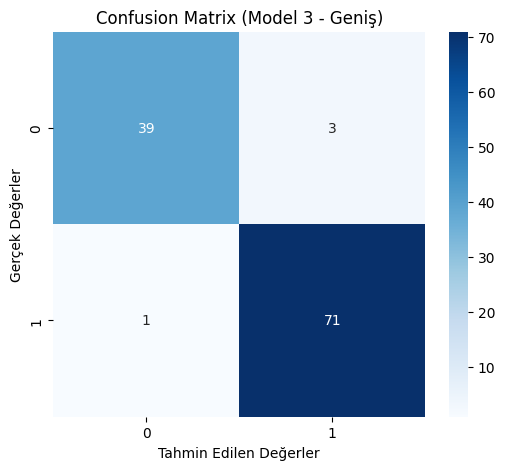

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({best_model_name})")
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

# 8.3 ROC Eğrisi

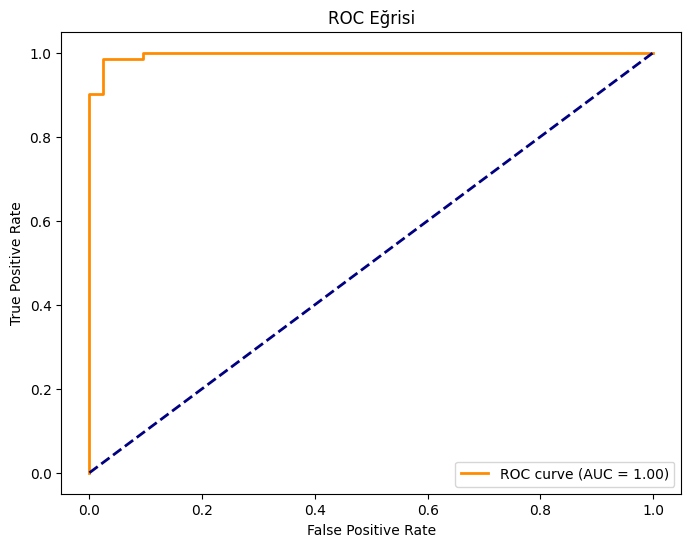

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

# **9. Optuna ile Hiperparametre Optimizasyonu (150 Deneme)**

In [ ]:
# Adım 1: Optuna Objective Fonksiyonu Tanımlama
def objective(trial):

    # 9.2 Arama Aralıkları

    # Katman sayısı (1 ile 3 arasında)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    for i in range(n_layers):
        # Her katmandaki nöron sayısı
        layers.append(trial.suggest_int(f"n_units_l{i}", 16, 256))

    # Diğer hiperparametreler
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Modeli Kurma
    clf = MLPClassifier(
        hidden_layer_sizes=tuple(layers),
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        max_iter=200, # Hızlandırmak için 200, sınır yoksa 500-1000 olabilir
        random_state=42,
        early_stopping=True
    )

    # 9.3 Eğitim Döngüsü
    clf.fit(X_train, y_train)

    # Validation Skoru
    val_acc = accuracy_score(y_val, clf.predict(X_val))

    return val_acc

# Adım 2: Optimizasyonu Başlatma
print("Optuna Optimizasyonu Başlatılıyor (150 Deneme)")
# 'study' değişkeni
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

# Adım 3: Sonuçları Raporlama (9.4)
print("\nOptuna Tarafından Bulunan En İyi Parametreler")
print(study.best_params)
print(f"En İyi Validation Accuracy Değeri: {study.best_value:.4f}")

# Adım 4: En İyi Modeli Yeniden Eğitme (SHAP için hazırlık)
print("\nEn iyi model yeniden eğitiliyor...")
best_params = study.best_params.copy()

# Parametreleri modele uygun hale getirme
layers = []
for k, v in best_params.items():
    if k.startswith("n_units"):
        layers.append(v)

final_params = {k: v for k, v in best_params.items() if not k.startswith("n_units") and k != "n_layers"}

optuna_model = MLPClassifier(hidden_layer_sizes=tuple(layers), **final_params, max_iter=1000, random_state=42)
optuna_model.fit(X_train, y_train)
print("Optuna modeli başarıyla oluşturuldu ve eğitildi.")

[I 2025-11-27 21:23:36,376] A new study created in memory with name: no-name-8684b47c-9c6a-49fd-a1e0-994f8c3ba65f


Optuna Optimizasyonu Başlatılıyor (150 Deneme)


[I 2025-11-27 21:23:36,914] Trial 0 finished with value: 0.9298245614035088 and parameters: {'n_layers': 3, 'n_units_l0': 20, 'n_units_l1': 246, 'n_units_l2': 122, 'learning_rate_init': 0.01776708033010193, 'alpha': 0.0020701961661620033, 'activation': 'relu', 'solver': 'sgd', 'batch_size': 128}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-11-27 21:23:38,409] Trial 1 finished with value: 0.8947368421052632 and parameters: {'n_layers': 3, 'n_units_l0': 215, 'n_units_l1': 229, 'n_units_l2': 200, 'learning_rate_init': 0.05394674209160284, 'alpha': 0.006268758411878311, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 128}. Best is trial 0 with value: 0.9298245614035088.
[I 2025-11-27 21:23:41,353] Trial 2 finished with value: 0.8596491228070176 and parameters: {'n_layers': 3, 'n_units_l0': 219, 'n_units_l1': 190, 'n_units_l2': 35, 'learning_rate_init': 0.00014514862243319854, 'alpha': 1.734411988250787e-06, 'activation': 'relu', 'solver': 'adam', 'batch_size': 128}. Best 


Optuna Tarafından Bulunan En İyi Parametreler
{'n_layers': 3, 'n_units_l0': 169, 'n_units_l1': 193, 'n_units_l2': 199, 'learning_rate_init': 0.06756627834244125, 'alpha': 0.0017579317753808432, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 128}
En İyi Validation Accuracy Değeri: 0.9825

En iyi model yeniden eğitiliyor...
Optuna modeli başarıyla oluşturuldu ve eğitildi.


# **10. XAI - SHAP Açıklanabilirlik Analizi**

X_train_np shape: (398, 30)
X_test_np shape: (114, 30)
Özellik sayısı: 30


SHAP için background veri hazırlandı.

10.1 SHAP Analizi: Model 3 - Geniş (Elle Seçilen En İyi Model)


  0%|          | 0/114 [00:00<?, ?it/s]

raw_shap_values type: <class 'numpy.ndarray'>
np.array(raw_shap_values).shape: (114, 30, 2)
shap_values_class1 shape: (114, 30)
Grafik 1: Özelliklerin Önem Sıralaması (Bar Plot)


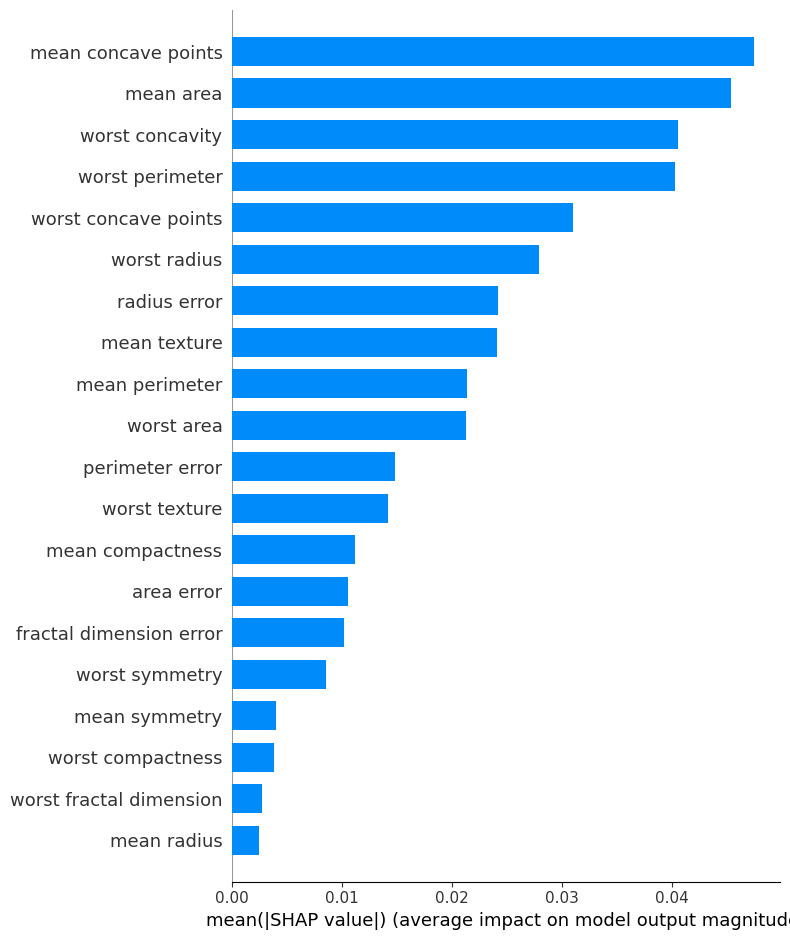

Grafik 2: Özellik Değerlerinin Etkisi (Summary Plot)


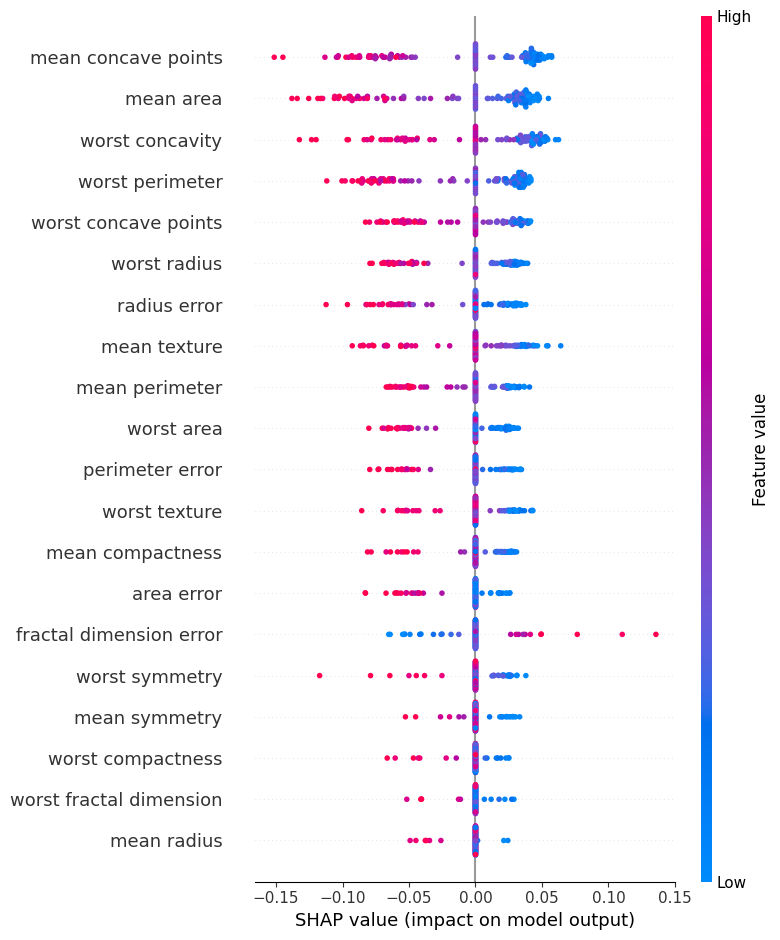


SHAP Analizi: Optuna Tarafından Bulunan Model


  0%|          | 0/114 [00:00<?, ?it/s]

np.array(raw_shap_values_opt).shape: (114, 30, 2)
shap_values_opt_class1 shape: (114, 30)
Grafik 3: Optuna Modeli Genel Bakış (Summary Plot)


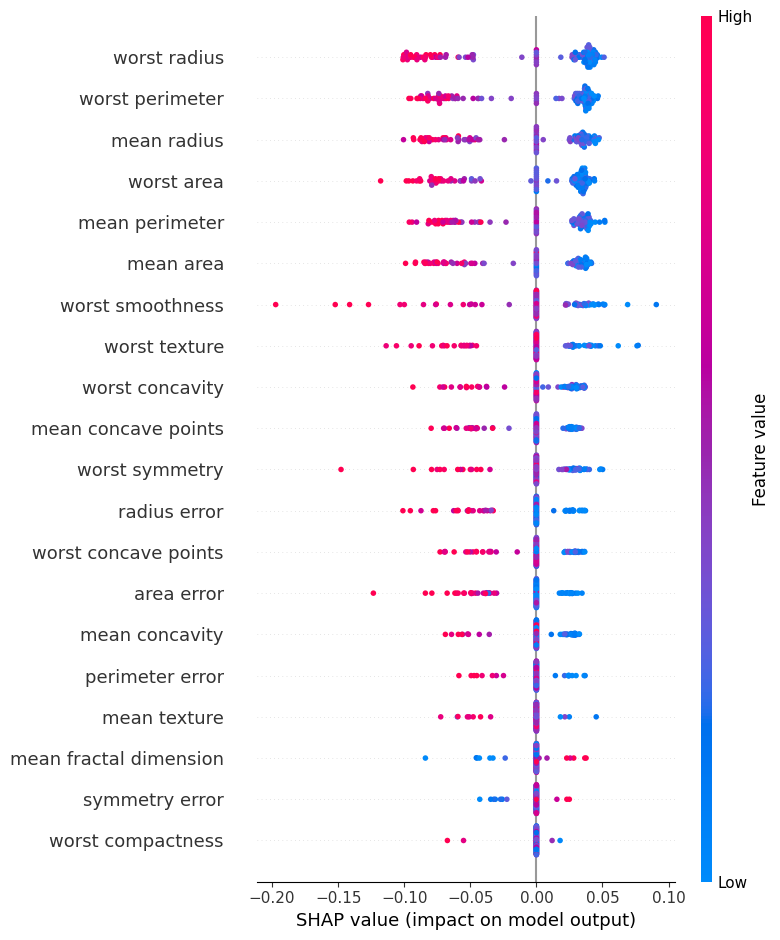

Grafik 4: Tek Bir Örnek İçin Karar Açıklaması (Force Plot)


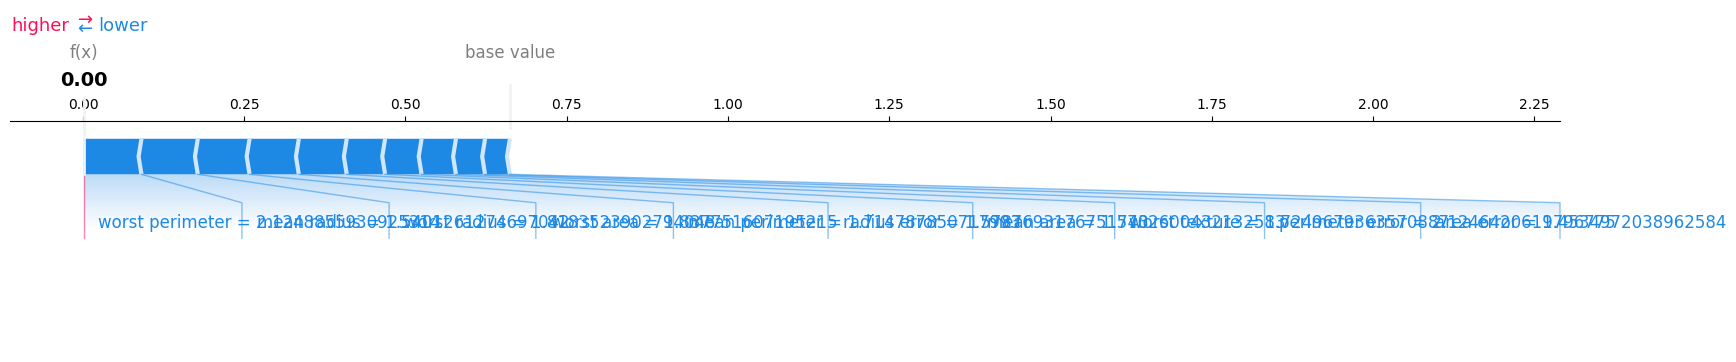

Grafik 5: Karar Yolu (Decision Plot - İlk 10 Örnek)


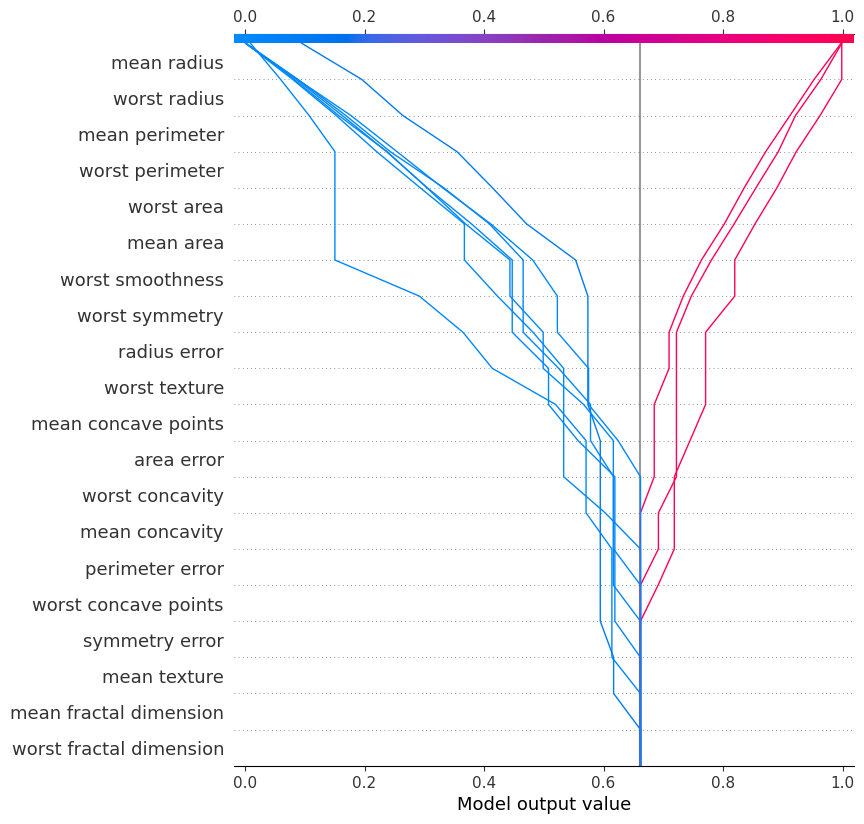

In [ ]:
# Yardımcı fonksiyon:
# SHAP çıktısını (eski / yeni) formata göre sınıf 1 için 2D matrise çevir
def get_class_shap_matrix(shap_values, class_idx=1):
    """
    SHAP farklı versiyonlarda farklı şekiller döndürebiliyor:
    - Eski stil: list of arrays: [array(nsamples, nfeatures), array(nsamples, nfeatures)]
    - Yeni stil: array(nsamples, nfeatures, nclasses)
    Bu fonksiyon hepsini nsamples x nfeatures forma çevirip geri döner.
    """
    # 1) List of arrays ise (eski API)
    if isinstance(shap_values, list):
        return shap_values[class_idx]

    # 2) array'e çevir
    sv = np.array(shap_values)

    # Tek çıkışlı model (nsamples, nfeatures)
    if sv.ndim == 2:
        return sv

    # Çok çıkışlı model (muhtemelen nsamples, nfeatures, nclasses)
    if sv.ndim == 3:
        # nsamples x nfeatures x nclasses - sınıf 1'in 2D matrisi
        return sv[:, :, class_idx]

    raise ValueError(f"Beklenmeyen shap_values boyutu: {sv.shape}")

# 0) X_train / X_test'i numpy'a çevir
if hasattr(X_train, "values"):
    X_train_np = X_train.values
else:
    X_train_np = X_train

if hasattr(X_test, "values"):
    X_test_np = X_test.values
else:
    X_test_np = X_test

feature_names = list(data.feature_names)

print("X_train_np shape:", X_train_np.shape)
print("X_test_np shape:", X_test_np.shape)
print("Özellik sayısı:", len(feature_names))

assert X_train_np.shape[1] == len(feature_names), "X_train ile feature_names kolon sayısı uyuşmuyor!"
assert X_test_np.shape[1] == len(feature_names), "X_test ile feature_names kolon sayısı uyuşmuyor!"

# SHAP grafikleri için JS başlat
shap.initjs()

# 1) Background (özet) veri: KernelExplainer için k-means
X_train_summary = shap.kmeans(X_train_np, 10)
print("SHAP için background veri hazırlandı.")

# 10.1 Seçilen MLP Modeli (best_model) İçin SHAP Analizi
print(f"\n10.1 SHAP Analizi: {best_model_name} (Elle Seçilen En İyi Model)")

X_test_sample = X_test_np

# Explainer oluşturuluyor
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_summary)

# SHAP değerleri hesaplanıyor
raw_shap_values = explainer.shap_values(X_test_sample)

print("raw_shap_values type:", type(raw_shap_values))
print("np.array(raw_shap_values).shape:", np.array(raw_shap_values).shape)

# Sınıf 1 için (pozitif sınıf) nsamples x nfeatures SHAP matrisi
shap_values_class1 = get_class_shap_matrix(raw_shap_values, class_idx=1)

print("shap_values_class1 shape:", shap_values_class1.shape)

assert shap_values_class1.shape[0] == X_test_sample.shape[0], "Satır sayısı (örnek sayısı) uyuşmuyor!"
assert shap_values_class1.shape[1] == X_test_sample.shape[1], "Kolon sayısı (özellik sayısı) uyuşmuyor!"

# Grafik 1: Özelliklerin Önem Sıralaması (Bar Plot)
print("Grafik 1: Özelliklerin Önem Sıralaması (Bar Plot)")
plt.figure()
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=feature_names,
    plot_type="bar"
)

# Grafik 2: Özellik Değerlerinin Etkisi (Summary Dot Plot)
print("Grafik 2: Özellik Değerlerinin Etkisi (Summary Plot)")
plt.figure()
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=feature_names
)

# 10.2 Optuna ile Bulunan En İyi Model (optuna_model) SHAP
print("\nSHAP Analizi: Optuna Tarafından Bulunan Model")

# Aynı background veriyi kullanıyoruz
explainer_opt = shap.KernelExplainer(optuna_model.predict_proba, X_train_summary)

X_test_sample_opt = X_test_np

raw_shap_values_opt = explainer_opt.shap_values(X_test_sample_opt)

print("np.array(raw_shap_values_opt).shape:", np.array(raw_shap_values_opt).shape)

shap_values_opt_class1 = get_class_shap_matrix(raw_shap_values_opt, class_idx=1)

print("shap_values_opt_class1 shape:", shap_values_opt_class1.shape)

assert shap_values_opt_class1.shape[0] == X_test_sample_opt.shape[0], "Satır sayısı uyuşmuyor! (optuna_model)"
assert shap_values_opt_class1.shape[1] == X_test_sample_opt.shape[1], "Kolon sayısı uyuşmuyor! (optuna_model)"

# Grafik 3: Optuna Modeli Genel Bakış (Summary Plot)
print("Grafik 3: Optuna Modeli Genel Bakış (Summary Plot)")
plt.figure()
shap.summary_plot(
    shap_values_opt_class1,
    X_test_sample_opt,
    feature_names=feature_names
)

# Grafik 4: Force Plot (Tek bir örnek için karar açıklaması)
print("Grafik 4: Tek Bir Örnek İçin Karar Açıklaması (Force Plot)")

force_fig = shap.force_plot(
    explainer_opt.expected_value[1] if np.ndim(explainer_opt.expected_value) > 0 else explainer_opt.expected_value,
    shap_values_opt_class1[0, :],
    X_test_sample_opt[0, :],
    feature_names=feature_names,
    matplotlib=True
)
plt.show()

# Grafik 5: Decision Plot (Karar yolu - ilk 10 örnek)
print("Grafik 5: Karar Yolu (Decision Plot - İlk 10 Örnek)")
shap.decision_plot(
    explainer_opt.expected_value[1] if np.ndim(explainer_opt.expected_value) > 0 else explainer_opt.expected_value,
    shap_values_opt_class1[:10],
    feature_names=feature_names
)
